<a href="https://colab.research.google.com/github/Hakuuri/ETLOpenFfacts/blob/main/ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Debug
import logging
logging.basicConfig(level=logging.DEBUG)

GROUPE 1 MORAGNY ALBAN, ABANCOURT ENZO, GORDILLO LOÏS

In [5]:
#
# import packages
import os
if not os.path.exists("spark-3.5.4-bin-hadoop3"):
    !wget -q https://dlcdn.apache.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
    !tar xf spark-3.5.4-bin-hadoop3.tgz
else:
    print("Spark is already downloaded and extracted.")

# Installer Java, Spark et findspark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!ls
# !tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

# Configurer les variables d'environnement
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

# Initialiser findspark
import findspark
findspark.init()


Spark is already downloaded and extracted.
drive  sample_data  spark-3.5.4-bin-hadoop3  spark-3.5.4-bin-hadoop3.tgz  spark-temp


In [6]:
# Import CSV openfoodfact

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

csv_path = '/content/drive/MyDrive/en.openfoodfacts.org.products.csv'

Mounted at /content/drive


In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("OpenFoodFacts Data Cleansing") \
    .config("spark.local.dir", "/content/spark-temp") \
    .getOrCreate()

In [8]:
# import 10% csv
import json
from pyspark.sql.functions import col, trim
import os
import shutil
import time

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Le fichier {csv_path} est introuvable.")
data = spark.read.csv(csv_path, header=True, inferSchema=True, sep="\t")

data = data.sample(fraction=0.01)  # récupère 1% du csv


In [9]:
# Test multiple enregistrement #
results = {}

In [16]:

start_time = time.time()
data.write.csv('/content/output_csv', mode='overwrite', header=True)
results['CSV'] = time.time() - start_time


In [17]:
start_time = time.time()
data.write.parquet('/content/output_parquet', mode='overwrite')
results['Parquet'] = time.time() - start_time

In [18]:
start_time = time.time()
spark.sql("CREATE DATABASE IF NOT EXISTS test_db")
data.write.saveAsTable("test_db.sample_data", mode='overwrite')
results['Hive'] = time.time() - start_time


In [19]:
for format, duration in results.items():
    print(f"Sauvegarde au format {format} : {duration:.2f} secondes")


Sauvegarde au format CSV : 126.15 secondes
Sauvegarde au format Parquet : 127.43 secondes
Sauvegarde au format Hive : 113.25 secondes


In [20]:
OutCsv_path = '/content/output_csv'
parquet_path = '/content/output_parquet'
hive_table = 'test_db.sample_data'

def measure_count_time(format_name, load_func):
    start_time = time.time()
    df = load_func()
    count = df.count()
    duration = time.time() - start_time
    return count, duration

In [21]:
# Mesurer pour CSV
csv_count, csv_duration = measure_count_time("CSV", lambda: spark.read.csv(OutCsv_path, header=True, inferSchema=True))


In [22]:
# Mesurer pour Parquet
parquet_count, parquet_duration = measure_count_time("Parquet", lambda: spark.read.parquet(parquet_path))

In [23]:
# Mesurer pour Hive
hive_count, hive_duration = measure_count_time("Hive", lambda: spark.sql(f"SELECT * FROM {hive_table}"))

In [24]:
print("Résultats de la performance :")
print(f"CSV : {csv_count} lignes, {csv_duration:.2f} secondes")
print(f"Parquet : {parquet_count} lignes, {parquet_duration:.2f} secondes")
print(f"Hive : {hive_count} lignes, {hive_duration:.2f} secondes")

Résultats de la performance :
CSV : 35312 lignes, 4.06 secondes
Parquet : 35312 lignes, 1.66 secondes
Hive : 35312 lignes, 0.91 secondes


In [25]:
start_time = time.time()
test = spark.sql(f"SELECT COUNT(*) FROM parquet.`{parquet_path}`").collect()
duration = time.time() - start_time
#print(f"Durée de lecture du fichier Parquet : {duration:.2f} secondes")

In [26]:
from pyspark.sql import DataFrame
import os
import shutil

# Chemin temporaire pour les fichiers Parquet
temp_output_path = "/content/output_parquet"
# Chemin final pour le fichier Parquet fusionné
final_output_path = "/content/cleaned_data_single.parquet"

# Fusionner les fichiers Parquet dans un seul fichier
def merge_parquet_files(temp_path, final_path):
    # Lire tous les fichiers Parquet dans le répertoire temporaire
    merged_df = spark.read.parquet(temp_path)

    # Écrire les données fusionnées dans un fichier unique
    merged_df.coalesce(1).write.mode("overwrite").parquet(final_path)
    print(f"=== Les données Parquet fusionnées ont été sauvegardées dans {final_path} ===")

# Appeler la fonction pour fusionner les fichiers
merge_parquet_files(temp_output_path, final_output_path)


=== Les données Parquet fusionnées ont été sauvegardées dans /content/cleaned_data_single.parquet ===


In [27]:
# Inspection initiale
print("=== Schéma initial des données ===")
data.printSchema()
print("=== Exemple de données brutes ===")

=== Schéma initial des données ===
root
 |-- code: double (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: integer (nullable = true)
 |-- created_datetime: timestamp (nullable = true)
 |-- last_modified_t: integer (nullable = true)
 |-- last_modified_datetime: timestamp (nullable = true)
 |-- last_modified_by: string (nullable = true)
 |-- last_updated_t: integer (nullable = true)
 |-- last_updated_datetime: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_t

In [28]:
# Chemin temporaire pour les fichiers Parquet
temp_output_path = "/content/output_parquet"
# Chemin final pour le fichier Parquet fusionné
final_output_path = "/content/cleaned_data_single.parquet"

# Lire les données depuis les fichiers Parquet multiples
data = spark.read.parquet(temp_output_path)

# Fusionner les données dans un seul fichier Parquet
data.coalesce(1).write.mode("overwrite").parquet(final_output_path)

In [29]:
# ETL_Cleaning

parquet_path = "/content/cleaned_data_single.parquet"

# Lire le fichier Parquet consolidé
dataParquet = spark.read.parquet(parquet_path)

# Vérifier le schéma des données
# dataParquet.printSchema()
dataParquet.show(5)

# Colonnes importantes
important_columns = [
    "product_name", "categories", "packaging", "brands", "nutriscore_score",
    "nutriscore_grade", "sodium_100g", "sugars_100g", "fat_100g", "proteins_100g", "quantity"
]

# Filtrer uniquement les colonnes disponibles
available_columns = dataParquet.columns
filtered_columns = [col for col in important_columns if col in available_columns]
print(f"Colonnes retenues : {filtered_columns}")

# Filtrer les données sur les colonnes disponibles
filtered_data = dataParquet.select(filtered_columns)

# Supprimer les valeurs manquantes dans les colonnes critiques
filtered_data = filtered_data.dropna(subset=["product_name", "categories"])
print(f"Nombre de lignes après suppression des valeurs manquantes : {filtered_data.count()}")

# Supprimer les doublons sur les colonnes critiques
filtered_data = filtered_data.dropDuplicates(subset=["product_name", "categories"])
print(f"Nombre de lignes après suppression des doublons : {filtered_data.count()}")

# Suppression des valeurs aberrantes
quantitative_columns = ["sugars_100g", "fat_100g", "proteins_100g", "sodium_100g"]
for column in quantitative_columns:
    quantiles = filtered_data.approxQuantile(column, [0.25, 0.75], 0.01)
    if quantiles and len(quantiles) == 2:
        Q1, Q3 = quantiles
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_data = filtered_data.filter(
            (col(column) >= lower_bound) & (col(column) <= upper_bound)
        )

# Afficher les statistiques finales après suppression des données aberrantes
print("=== Statistiques après suppression des données aberrantes ===")
filtered_data.describe(["sugars_100g", "fat_100g", "proteins_100g", "sodium_100g"]).show()



# Sauvegarder les données nettoyées au format Parquet
output_path = "/content/cleaned_data_single_parquet"

# Écrire les données dans un fichier Parquet unique
filtered_data.coalesce(1).write.mode("overwrite").parquet(output_path)




+-----------------+--------------------+---------+----------+-------------------+---------------+----------------------+----------------+--------------+---------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+----------+-----------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+--------------------+--------------------+--------------------+----------+--------------+------------------------+------+--------------------+---------------+------+---------+--------------+------------+--------------------+--------------------+-------------------------+--------------------+------------+--------------------+--------------------+--------------------+------------+----------------+-----------------+-----------+---------+--------------+------------+----------------+----------------+----------+--------------+-------------+

In [30]:
# ETL_Analyse

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, row_number
from pyspark.sql.window import Window
import os

# Initialiser Spark
spark = SparkSession.builder.appName("ETL_Analyse_Parquet").getOrCreate()

# Définir le chemin du fichier nettoyé au format Parquet
input_cleaned_path = "/content/cleaned_data_single_parquet"

# Vérifier si le fichier existe
if not os.path.exists(input_cleaned_path):
    raise FileNotFoundError(f"Fichier nettoyé introuvable à l'emplacement : {input_cleaned_path}")

# Charger les données nettoyées au format Parquet
data_cleaned = spark.read.parquet(input_cleaned_path)

# Inspection initiale
print("=== Exemple de données nettoyées ===")
data_cleaned.show(10, truncate=False)

# Produits les plus caloriques par catégorie
data_cleaned = data_cleaned.withColumn(
    "calories", 4 * (col("sugars_100g") + col("proteins_100g")) + 9 * col("fat_100g")
)
window_spec = Window.partitionBy("categories").orderBy(col("calories").desc())
most_caloric = data_cleaned.filter(col("calories").isNotNull()) \
    .withColumn("rank", row_number().over(window_spec)) \
    .filter(col("rank") == 1) \
    .select("categories", "product_name", "calories")
print("=== Produits les plus caloriques par catégorie ===")
most_caloric.show(10, truncate=False)

# Tendances de production par marque
trends_by_brand = data_cleaned.filter(col("brands").isNotNull()) \
    .groupBy("brands") \
    .agg(count("*").alias("product_count")) \
    .orderBy(col("product_count").desc())
print("=== Tendances de production par marque ===")
trends_by_brand.show(10, truncate=False)

# Statistiques descriptives par catégorie
category_stats = data_cleaned.groupBy("categories").agg(
    avg("sodium_100g").alias("avg_sodium"),
    avg("sugars_100g").alias("avg_sugars"),
    avg("fat_100g").alias("avg_fat"),
    avg("proteins_100g").alias("avg_proteins"),
    count("*").alias("product_count"),
    avg("quantity").alias("avg_quantity")
).filter(col("product_count") >= 50) \
 .orderBy(col("avg_sodium").desc())
print("=== Statistiques descriptives par catégorie ===")
category_stats.show(10, truncate=False)

# Arrêter Spark
# spark.stop()

=== Exemple de données nettoyées ===
+-------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------+------------------------+----------------+----------------+-----------------+-----------+---------------+---------------+---------+
|product_name                               |categories                                                                                                                                                                                                                                                                                                                                       |packaging

In [31]:
#ETL_Dataviz

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Définir le chemin du fichier Parquet nettoyé
input_cleaned_path = "/content/cleaned_data_single_parquet"


# Vérifier si le fichier Parquet existe
if not os.path.exists(input_cleaned_path):
    raise FileNotFoundError(f"Fichier Parquet introuvable à l'emplacement : {input_cleaned_path}")

# Charger les données nettoyées au format Parquet
filtered_data = pd.read_parquet(input_cleaned_path)

# Afficher un aperçu des données
print("=== Aperçu des données ===")
print(filtered_data.head())

# Vérifier les colonnes disponibles
print("=== Colonnes disponibles ===")
print(filtered_data.columns)

=== Aperçu des données ===
                                  product_name  \
0  "alla norma" with eggplant & ricotta salata   
1                        0% Strawberry Yogourt   
2                   0% azúcar manzana y canela   
3                            1 % lowfat yogurt   
4                         1 / 2 Cassoulet Timo   

                                          categories  \
0                      Condiments, Sauces, Groceries   
1  Dairies, Fermented foods, Desserts, Fermented ...   
2  Alimentos y bebidas de origen vegetal, Aliment...   
3  Dairies, Fermented foods, Desserts, Fermented ...   
4  Viandes et dérivés, Plats préparés, Plats prép...   

                                           packaging   brands  \
0                                               None     None   
1  Metal, Plastic, Recyclable Metals, Aluminium, ...  Siggi's   
2                                      Box,Container   QUAKER   
3                                               None  Spartan   
4         

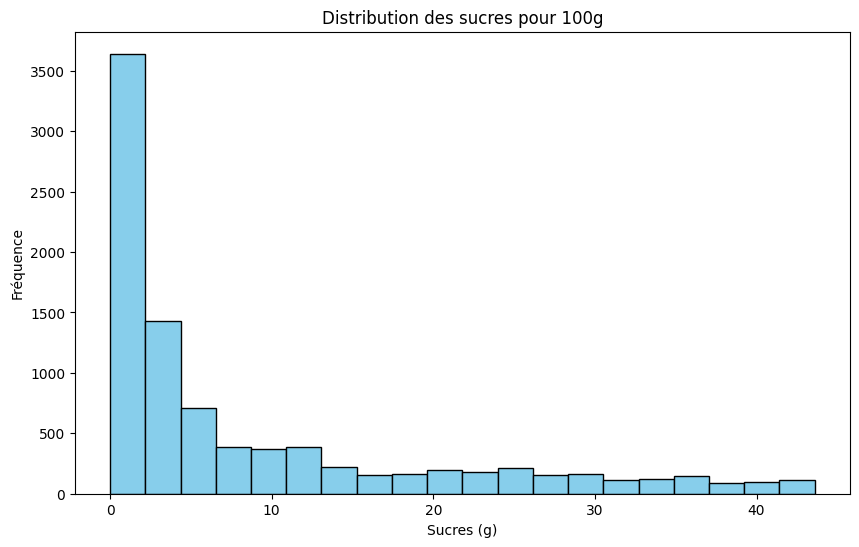

In [32]:
# 1. **Histogramme de la distribution des sucres (`sugars_100g`)**
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['sugars_100g'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des sucres pour 100g")
plt.xlabel("Sucres (g)")
plt.ylabel("Fréquence")
plt.show()

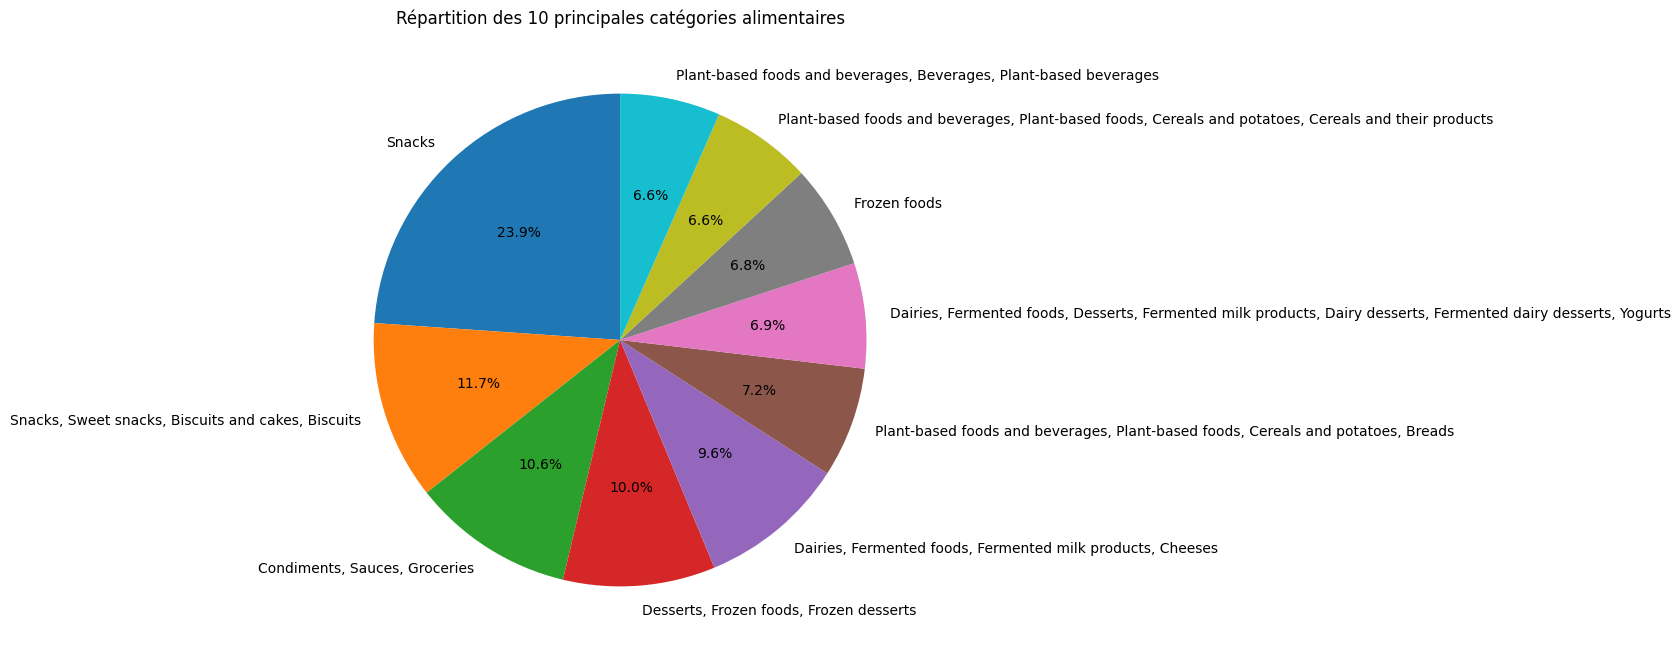

In [33]:
category_counts = filtered_data['categories'].value_counts().nlargest(10)
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des 10 principales catégories alimentaires")
plt.show()

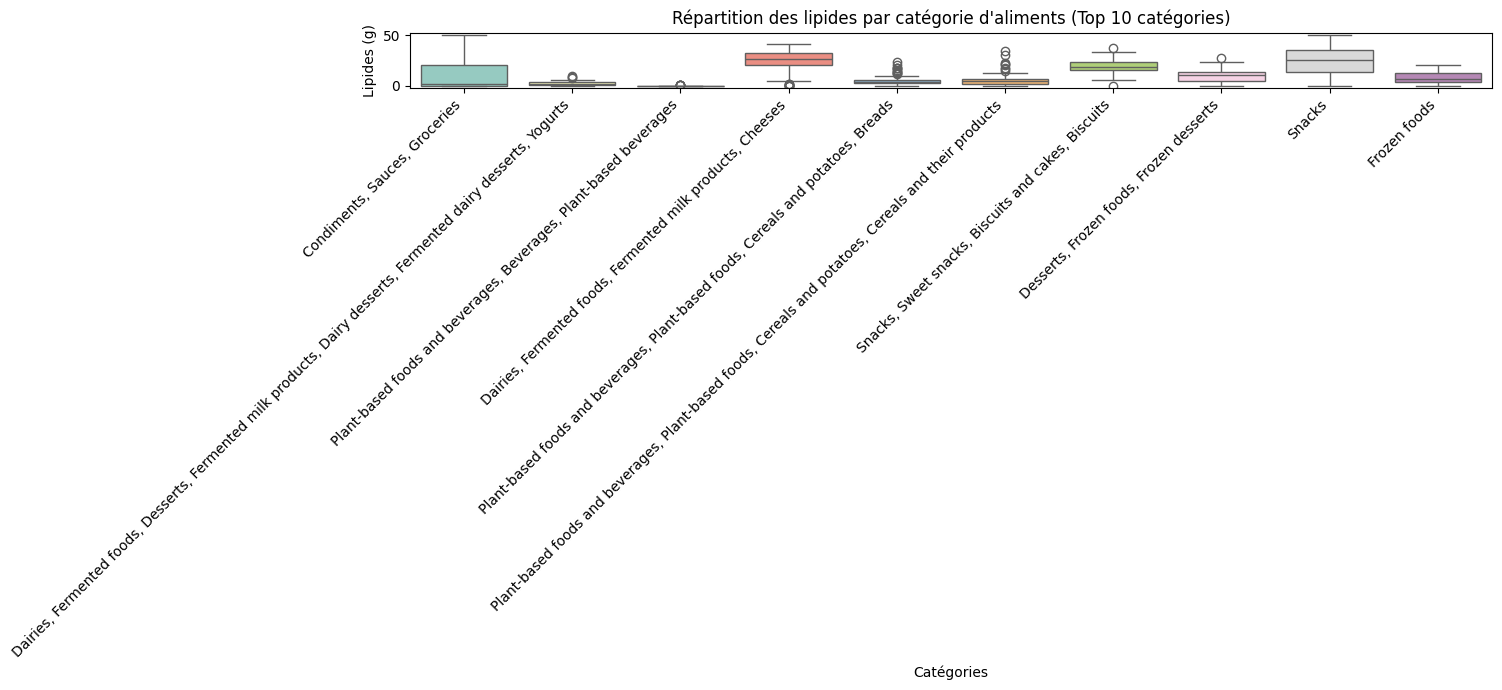

In [41]:
# Filtrer les données pour les colonnes pertinentes
filtered_data_sample = filtered_data.dropna(subset=['fat_100g', 'categories'])

# Limiter aux 10 catégories les plus fréquentes
top_categories = filtered_data_sample['categories'].value_counts().index[:10]
filtered_data_sample = filtered_data_sample[filtered_data_sample['categories'].isin(top_categories)]

# Créer le boxplot
plt.figure(figsize=(15, 7))
sns.boxplot(x='categories', y='fat_100g', data=filtered_data_sample, hue='categories', palette="Set3", legend=False)

# Ajuster l'affichage des catégories
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour lisibilité
plt.title("Répartition des lipides par catégorie d'aliments (Top 10 catégories)")
plt.ylabel("Lipides (g)")
plt.xlabel("Catégories")
plt.tight_layout()  # Pour éviter les chevauchements
plt.show()

In [35]:
# 3. **Histogramme interactif des protéines (`proteins_100g`)**
fig = px.histogram(
    filtered_data,
    x='proteins_100g',
    nbins=20,
    title="Distribution des protéines (g/100g)",
    labels={'proteins_100g': 'Protéines (g)'}
)
fig.show()

In [36]:
# 4. **Nuage de points interactif : relation entre sucres et lipides**
fig = px.scatter(
    filtered_data,
    x='sugars_100g',
    y='fat_100g',
    color='brands',
    title="Relation entre les sucres et les lipides",
    labels={'sugars_100g': 'Sucres (g)', 'fat_100g': 'Lipides (g)'},
    size_max=10
)
fig.show()


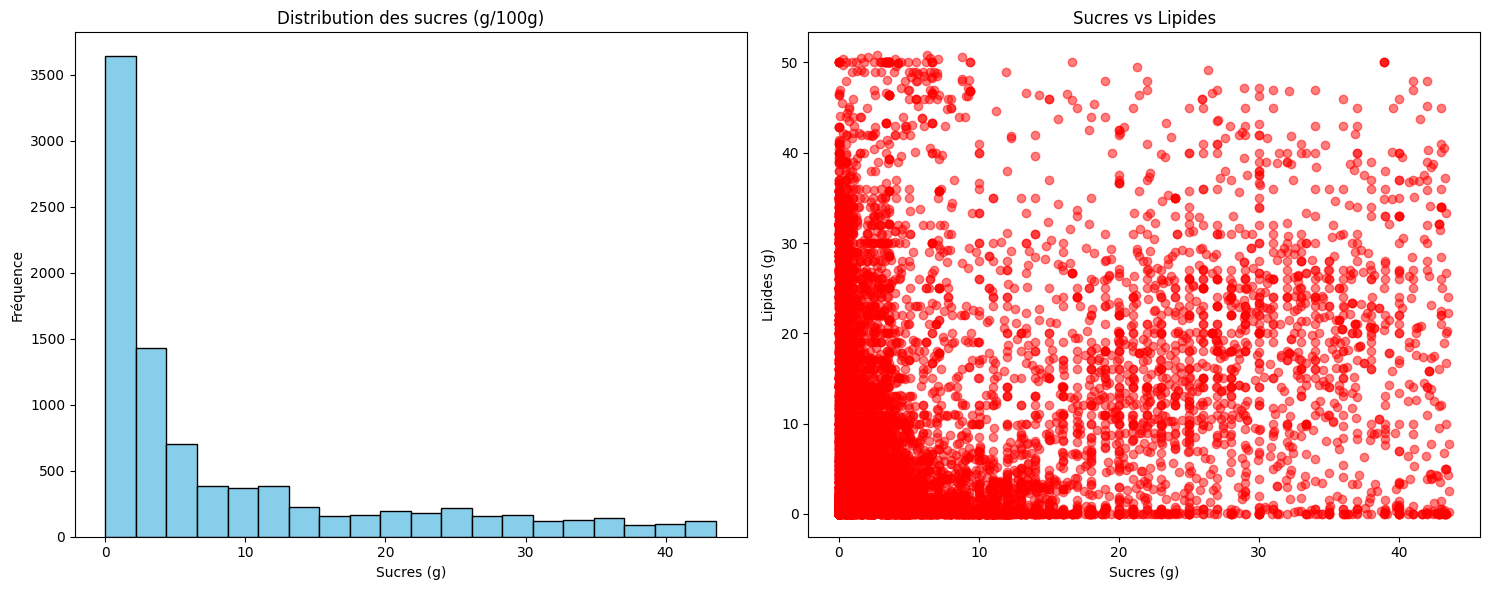

In [37]:
import matplotlib.pyplot as plt

# Définir la figure avec deux sous-graphiques (subplots)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Taille ajustée pour un affichage clair

# Graphique 1 : Histogramme des sucres
axes[0].hist(filtered_data['sugars_100g'].dropna(), bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("Distribution des sucres (g/100g)")
axes[0].set_xlabel("Sucres (g)")
axes[0].set_ylabel("Fréquence")

# Graphique 2 : Relation sucres/lipides
axes[1].scatter(filtered_data['sugars_100g'], filtered_data['fat_100g'], color='red', alpha=0.5)
axes[1].set_title("Sucres vs Lipides")
axes[1].set_xlabel("Sucres (g)")
axes[1].set_ylabel("Lipides (g)")

# Ajuster la mise en page pour éviter les chevauchements
plt.tight_layout()

# Afficher les graphiques
plt.show()


In [38]:
from pyspark.sql.functions import col, count
import pandas as pd
from IPython.display import display

# Tendances de production par marque
trends_by_brand = data_cleaned.filter(col("brands").isNotNull()) \
    .groupBy("brands") \
    .agg(count("*").alias("product_count")) \
    .orderBy(col("product_count").desc())

# Convertir le DataFrame Spark en DataFrame Pandas
trends_by_brand_pd = trends_by_brand.limit(10).toPandas()

# Appliquer un style pour améliorer l'affichage
styled_table = trends_by_brand_pd.style.set_table_styles(
    [
        {'selector': 'th', 'props': [('font-size', '14px'), ('text-align', 'center'), ('background-color', '#f4f4f4'), ('color', '#333')]},
        {'selector': 'td', 'props': [('font-size', '12px'), ('text-align', 'center'), ('background-color', '#ffffff'), ('color', '#000')]},
    ]
).set_properties(**{'border': '1px solid black'})

# Supprimer l'index manuellement
trends_by_brand_pd.reset_index(drop=True, inplace=True)

# Afficher le tableau stylisé
print("=== Tendances de production par marque ===")
display(styled_table)



=== Tendances de production par marque ===


,brands,product_count
0,Carrefour,95
1,Auchan,80
2,Hacendado,46
3,U,42
4,Coop,37
5,Casino,35
6,Delhaize,34
7,Cora,28
8,Tesco,27
9,Picard,25


In [39]:
# 6. **Statistiques descriptives des macronutriments**
print("=== Statistiques descriptives ===")
stats = filtered_data[['sugars_100g', 'fat_100g', 'proteins_100g']].describe()
print(stats)



=== Statistiques descriptives ===
       sugars_100g     fat_100g  proteins_100g
count  9063.000000  9063.000000    9063.000000
mean      8.655335    11.138235       8.028927
std      11.157090    12.264483       7.237511
min       0.000000     0.000000       0.000000
25%       0.700000     1.000000       2.100000
50%       3.401361     6.250000       6.200000
75%      12.100000    18.810000      12.000000
max      43.600000    50.800000      29.000000


In [40]:
# 7. **Sauvegarde des statistiques au format Parquet**
output_parquet_path = "macronutrient_statistics.parquet"
stats_df = stats.reset_index()  # Convertir en DataFrame pour sauvegarder
stats_df.to_parquet(output_parquet_path, index=False)
print(f"Statistiques descriptives sauvegardées au format Parquet dans : {output_parquet_path}")

Statistiques descriptives sauvegardées au format Parquet dans : macronutrient_statistics.parquet
